In [1]:
from random_croping import ResizeRandomCrop

In [3]:
cropper=ResizeRandomCrop(data_file="data/val",crop_size=(1280,720),rescale_size=(1920,1080),num_of_crops=2,annotations="data/data_parsed.json")
cropper.crop()


 Object of class "RandomCrop" has been initialized.


In [2]:
import tensorflow as tf
import json,os,cv2,numpy as np

In [3]:
with open("output/annotations_cropped.json","r") as f:
    labels=json.load(f)


In [4]:
len(labels)

3094

In [5]:
image_paths=[]
image_labels=[]
for img_name in labels.keys():
    image_paths.append(os.path.join("output",labels[img_name]["file_name"]))
    label=0
    for annotation in labels[img_name]["annotations"]:
        if annotation["category_id"]==1:
          label=1
          break
    image_labels.append(label)


In [6]:
train_size = int(0.7 * len(image_paths))

train_paths = image_paths[:train_size]
train_labels=image_labels[:train_size]

val_paths=image_paths[train_size:]
val_labels=image_labels[train_size:]

In [7]:
len(train_paths), len(val_paths)  

(2165, 929)

In [8]:
from tensorflow.keras import layers, models

In [9]:
model=models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(720, 1280, 3)),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.BatchNormalization(),


    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])
model.summary()

C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 718, 1278, 32)  │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 359, 639, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 359, 639, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 357, 637, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 178, 318, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 178, 318, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 176, 316, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 88, 158, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 889856)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │   113,901,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 113,958,529 (434.72 MB)

 Trainable params: 113,958,337 (434.72 MB)

 Non-trainable params: 192 (768.00 B)

In [10]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [11]:
tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True,
)

In [12]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, labels, batch_size=8, img_size=(1280, 720), shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_paths) // self.batch_size

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_paths = [self.image_paths[i] for i in batch_indexes]
        batch_labels = [self.labels[i] for i in batch_indexes]

        # Charger et redimensionner les images du batch
        X = np.array([self.load_image(path) for path in batch_paths])
        y = np.array(batch_labels)

        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_image(self, path):
        # Lire et redimensionner l'image en 720p avec OpenCV
        image = cv2.imread(path)
        image = cv2.resize(image, self.img_size)
        return image / 255.0  # Normaliser entre 0 et 1

# Créer une instance du DataGenerator
batch_size = 8
train_gen = DataGenerator(train_paths, train_labels, batch_size=batch_size, img_size=(1280, 720))
val_gen=DataGenerator(val_paths, val_labels, batch_size=batch_size, img_size=(1280, 720))


In [ ]:
history=model.fit(train_gen,validation_data=val_gen,epochs=5,callbacks=[tf.keras.callbacks.EarlyStopping()])

Epoch 1/5



KeyboardInterrupt



In [ ]:
model.save("human_detector.h5")

In [15]:
model=tf.keras.models.load_model("models/human_detector.h5")

In [16]:
model.evaluate(val_gen)

C:\Users\aaron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


116/116 ━━━━━━━━━━━━━━━━━━━━ 76s 619ms/step - accuracy: 0.9015 - loss: 0.5746


[0.49693799018859863, 0.9051724076271057]

In [18]:
import matplotlib.pyplot as plt
import random

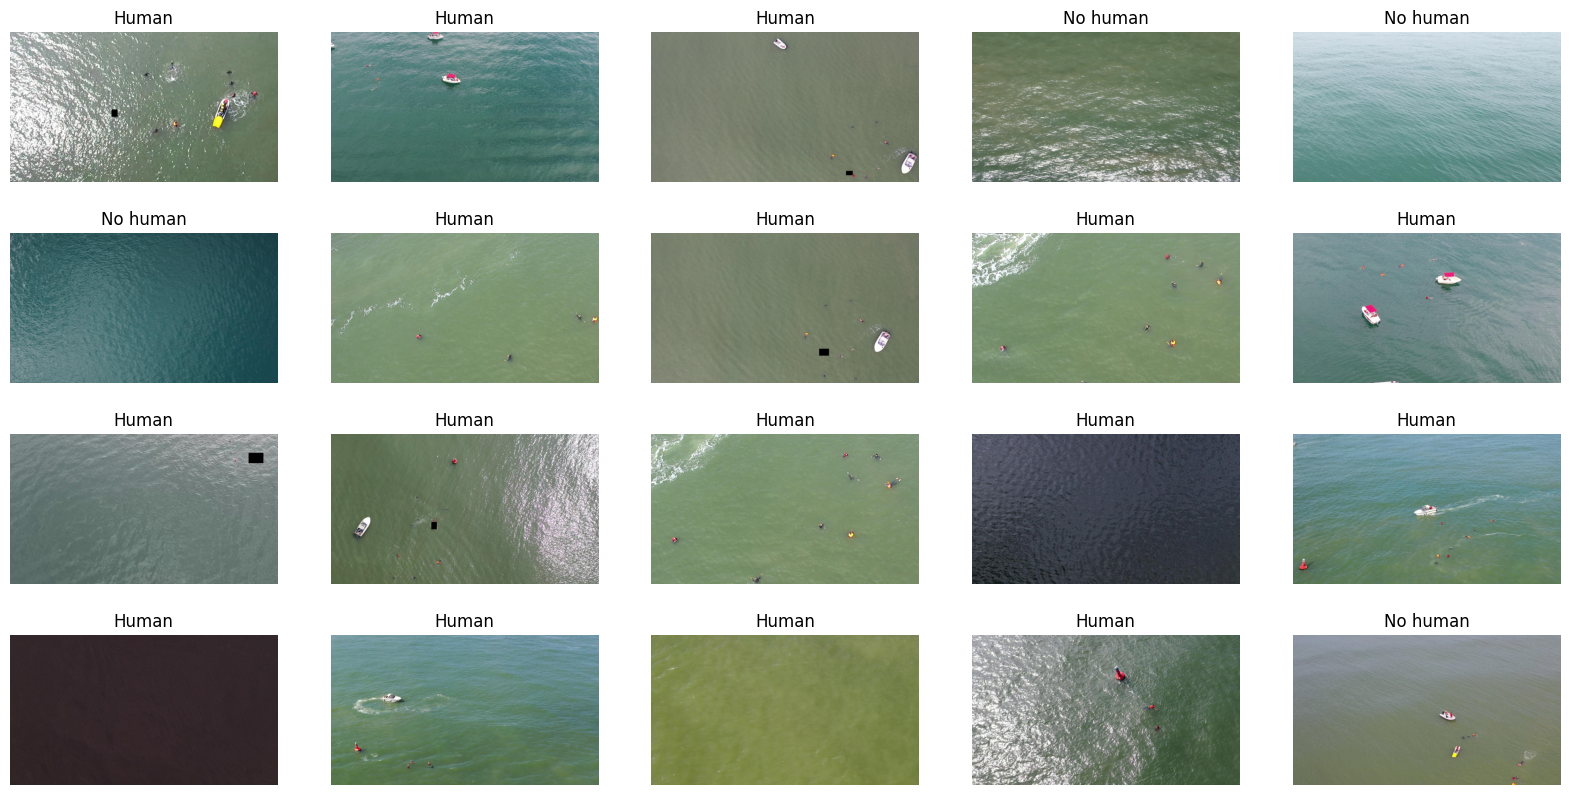

In [27]:
plt.figure(figsize=(20, 10))

for i in range(20):
    image_name = random.choice(os.listdir("output"))
    image_path = os.path.join("output", image_name)
    
    # Charger et prétraiter l'image
    img = cv2.imread(image_path)
    img = cv2.resize(img, (1280, 720))
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    
    # Prédire avec le modèle
    prediction = model.predict(img, verbose=0)
    
    # Afficher l'image dans la grille
    plt.subplot(4, 5, i + 1)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title("Human" if prediction > 0.9 else "No human")
    plt.axis("off")

plt.show()